## Import

In [1]:
import random
import pandas as pd
import numpy as np
import os
import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings(action='ignore') 

In [48]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=1)

## Hyperparameter Setting

In [3]:
CFG = {
    'WIDTH':48,
    'HEIGHT':72,
    'EPOCHS':10,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':128,
    'SEED':41
}

## Fixed RandomSeed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing

In [5]:
data_path = '/shared/Samsung'
simulation_sem_paths = sorted(glob.glob(f'{data_path}/simulation_data/SEM/*/*/*.png'))
simulation_depth_paths = sorted(glob.glob(f'{data_path}/simulation_data/Depth/*/*/*.png'))

In [16]:
# Depth 이미지 1개당 2개의 Simulator Hole 단위 SEM 영상이 Pair하게 매칭됩니다. (Name_itr0, Name_itr1)
simulation_sem_paths[:2], simulation_depth_paths[0]

(['/shared/Samsung/simulation_data/SEM/Case_1/80/20201001_202940_NE142400C_RAE01_1_S01_M0005-01MS_3_itr0.png',
  '/shared/Samsung/simulation_data/SEM/Case_1/80/20201001_202940_NE142400C_RAE01_1_S01_M0005-01MS_3_itr1.png'],
 '/shared/Samsung/simulation_data/Depth/Case_1/80/20201001_202940_NE142400C_RAE01_1_S01_M0005-01MS_3.png')

In [15]:
# SEM 데이터가 depth보다 정확히 2배 많음
len(simulation_sem_paths) == len(simulation_depth_paths) * 2

True

In [24]:
data_len = len(simulation_sem_paths) # == len(simulation_depth_paths) * 2
data_len

173304

In [23]:
split_num = int(data_len*0.8) // 2

train_sem_paths = simulation_sem_paths[:split_num*2]
train_depth_paths = simulation_depth_paths[:split_num]

val_sem_paths = simulation_sem_paths[split_num*2:]
val_depth_paths = simulation_depth_paths[split_num:]

len(train_sem_paths), len(train_depth_paths), len(val_sem_paths), len(val_depth_paths)

(138642, 69321, 34662, 17331)

## CustomDataset

In [28]:
for i in range(4):
    if i % 2 == 0:
        d_i = i // 2
    else:
        d_i = (i-1) // 2
    print(i, d_i)

0 0
1 0
2 1
3 1


In [29]:
class CustomDataset(Dataset):
    def __init__(self, sem_path_list, depth_path_list):
        self.sem_path_list = sem_path_list
        self.depth_path_list = depth_path_list
        
    def __getitem__(self, index):
        sem_path = self.sem_path_list[index]
        sem_img = cv2.imread(sem_path, cv2.IMREAD_GRAYSCALE)
        sem_img = np.expand_dims(sem_img, axis=-1).transpose(2,0,1)
        sem_img = sem_img / 255.
        
        depth_index = index // 2 if index % 2 == 0 else (index-1) // 2

        if self.depth_path_list is not None:
            depth_path = self.depth_path_list[depth_index]
            depth_img = cv2.imread(depth_path, cv2.IMREAD_GRAYSCALE)
            depth_img = np.expand_dims(depth_img, axis=-1).transpose(2,0,1)
            depth_img = depth_img / 255.
            return torch.Tensor(sem_img), torch.Tensor(depth_img) # B,C,H,W
        else:
            img_name = sem_path.split('/')[-1]
            return torch.Tensor(sem_img), img_name # B,C,H,W
        
    def __len__(self):
        return len(self.sem_path_list)

In [30]:
train_dataset = CustomDataset(train_sem_paths, train_depth_paths)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=6)

val_dataset = CustomDataset(val_sem_paths, val_depth_paths)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=6)

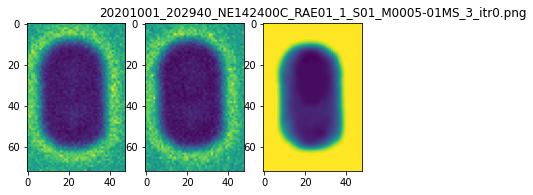

In [42]:
import matplotlib.pyplot as plt

ex_idx = 0
img_name = train_sem_paths[ex_idx].split('/')[-1]

imgs = [
    train_dataset[ex_idx][0].permute(1, 2, 0),
    train_dataset[ex_idx+1][0].permute(1, 2, 0),
    train_dataset[ex_idx][1].permute(1, 2, 0)
]

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(imgs[i])
plt.title(img_name)
None

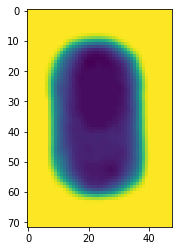

In [34]:
plt.imshow()

## Model Define

In [43]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(CFG['HEIGHT']*CFG['WIDTH'], 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(), 
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, CFG['HEIGHT']*CFG['WIDTH']),
        )
        
    def forward(self, x):
        x = x.view(-1, CFG['HEIGHT']*CFG['WIDTH'])
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 1, CFG['HEIGHT'], CFG['WIDTH'])
        return x

## Train

In [44]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.L1Loss().to(device)
    best_score = 999999
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for sem, depth in tqdm(iter(train_loader)):
            sem = sem.float().to(device)
            depth = depth.float().to(device)
            
            optimizer.zero_grad()
            
            model_pred = model(sem)
            loss = criterion(model_pred, depth)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        val_loss, val_rmse = validation(model, criterion, val_loader, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] Val RMSE : [{val_rmse:.5f}]')
        
        if best_score > val_rmse:
            best_score = val_rmse
            best_model = model
        
        if scheduler is not None:
            scheduler.step()
            
    return best_model

In [45]:
def validation(model, criterion, val_loader, device):
    model.eval()
    rmse = nn.MSELoss().to(device)
    
    val_loss = []
    val_rmse = []
    with torch.no_grad():
        for sem, depth in tqdm(iter(val_loader)):
            sem = sem.float().to(device)
            depth = depth.float().to(device)
            
            model_pred = model(sem)
            loss = criterion(model_pred, depth)
            
            pred = (model_pred*255.).type(torch.int8).float()
            true = (depth*255.).type(torch.int8).float()
            
            b_rmse = torch.sqrt(criterion(pred, true))
            
            val_loss.append(loss.item())
            val_rmse.append(b_rmse.item())

    return np.mean(val_loss), np.mean(val_rmse)

## Run!!

In [49]:
model = BaseModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = None

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [0.04292] Val Loss : [0.05598] Val RMSE : [4.48856]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [2] Train Loss : [0.02444] Val Loss : [0.01987] Val RMSE : [2.84511]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [3] Train Loss : [0.01831] Val Loss : [0.02458] Val RMSE : [3.05381]


  0%|          | 0/1084 [00:30<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [4] Train Loss : [0.01677] Val Loss : [0.02037] Val RMSE : [2.82435]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [5] Train Loss : [0.01464] Val Loss : [0.02939] Val RMSE : [3.28892]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [6] Train Loss : [0.01397] Val Loss : [0.01556] Val RMSE : [2.57227]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [7] Train Loss : [0.01297] Val Loss : [0.01745] Val RMSE : [2.66804]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [8] Train Loss : [0.01203] Val Loss : [0.03400] Val RMSE : [3.65477]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [9] Train Loss : [0.01179] Val Loss : [0.01706] Val RMSE : [2.67845]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [10] Train Loss : [0.01069] Val Loss : [0.03586] Val RMSE : [3.58781]


## Inference & Submission

In [50]:
test_sem_path_list = sorted(glob.glob(f'{data_path}/test/SEM/*.png'))

In [51]:
test_dataset = CustomDataset(test_sem_path_list, None)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=6)

In [52]:
import zipfile
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    
    result_name_list = []
    result_list = []
    with torch.no_grad():
        for sem, name in tqdm(iter(test_loader)):
            sem = sem.float().to(device)
            model_pred = model(sem)
            
            for pred, img_name in zip(model_pred, name):
                pred = pred.cpu().numpy().transpose(1,2,0)*255.
                save_img_path = f'{img_name}'
                #cv2.imwrite(save_img_path, pred)
                result_name_list.append(save_img_path)
                result_list.append(pred)
    
    os.makedirs('./submission', exist_ok=True)
    os.chdir("./submission/")
    sub_imgs = []
    for path, pred_img in zip(result_name_list, result_list):
        cv2.imwrite(path, pred_img)
        sub_imgs.append(path)
    submission = zipfile.ZipFile("../submission.zip", 'w')
    for path in sub_imgs:
        submission.write(path)
    submission.close()

In [53]:
inference(infer_model, test_loader, device)

  0%|          | 0/204 [00:00<?, ?it/s]